# Objective

Train a neural network to classify bird species.

Dataset: https://www.kaggle.com/datasets/gpiosenka/100-bird-species

### About Dataset

Data set of **400 bird species**. 58388 training images, 2000 test images(5 images per species) and 2000 validation images (5 images per species). This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image. As a result even a moderatly complex model will achieve training and test accuracies in the mid 90% range.
All images are **224 X 224 X 3 color images in jpg** format. Data set includes a train set, test set and validation set. Each set contains 400 sub directories, one for each bird species. The data structure is convenient if you use the Keras ImageDataGenerator.flowfromdirectory to create the train, test and valid data generators. The data set also include a file Bird Species.csv. This cvs file contains three columns. The filepaths column contains the file path to an image file. The labels column contains the class name associated with the image file. The Bird Species.csv file if read in using df= pandas.birdscsv(Bird Species.csv) will create a pandas dataframe which then can be split into traindf, testdf and validdf dataframes to create your own partitioning of the data into train, test and valid data sets.
NOTE: The test and validation images in the data set were hand selected to be the "best" images so your model will probably get the highest accuracy score using those data sets versus creating your own test and validation sets. However the latter case is more accurate in terms of model performance on unseen images.

Images were gather from internet searches by species name. Once the image files for a species was downloaded they were checked for duplicate images using a python duplicate image detector program I developed. All duplicates detected were deleted in order to prevent their being images common between the training, test and validation sets.
After that the images were cropped so that the bird occupies at least 50% of the pixel in the image. Then the images were resized to 224 X 224 X3 in jpg format. The cropping ensures that when processed by a CNN their is adequate information in the images to create a highly accurate classifier. Even a moderately robust model should achieve training, validation and test accuracies in the high 90% range. Because of the large size of the dataset I recommend if you try to train a model use and image size of 150 X 150 X3 in order to reduce training time. All files were also numbered sequential starting from one for each species. So test images are named 1.jpg to 5.jpg. Similarly for validation images. Training images are also numbered sequentially with "zeros" padding. For example 001.jpg, 002.jpg ….010.jpg, 011.jpg …..099.jpg, 100jpg, 102.jpg etc. The zero's padding preserves the file order when used with python file functions and Keras flow from directory.

The training set is not balanced, having a varying number of files per species. However each species has at least 120 training image files. This imbalanced did not effect my kernel classifier as it achieved over 98% accuracy on the test set.
One significant imbalance in the data set is the ratio of male species images to female species images. About 85% of the images are of the male and 15% of the female. Males typical are far more diversely colored while the females of a species are typically bland. Consequently male and female images may look entirely different .Almost all test and validation images are taken from the male of the species. Consequently the classifier may not perform as well on female specie images.

# Setup

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

# packages for modelling and evaluation
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.utils import make_grid
    
# packages for plotting
import matplotlib.pyplot as plt
import matplotlib. image as mpimg
import seaborn as sns

# set a fixed random state to produce the same results
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

/home/dkrz/k202143/miniconda3/envs/gen_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [2]:
data_path = 'data'

birds_df = pd.read_csv(os.path.join(data_path, "birds.csv"))

In [3]:
birds_df.head()

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [4]:
birds_df.tail()

,class index,filepaths,labels,data set
62383,399,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
62384,399,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
62385,399,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
62386,399,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid
62387,399,valid/YELLOW HEADED BLACKBIRD/5.jpg,YELLOW HEADED BLACKBIRD,valid


In [5]:
birds_df["data set"].unique()

array(['train', 'test', 'valid'], dtype=object)

Create three dataframes corresponding to ```train```, ```test``` and ```valid```

In [6]:
birds_df_train = birds_df[birds_df["data set"] == "train"]
birds_df_valid = birds_df[birds_df["data set"] == "valid"]
birds_df_test = birds_df[birds_df["data set"] == "test"]

How many ```train```, ```valid``` and ```test``` images do we have?

In [7]:
print(f'Train data set length: {len(birds_df_train)}')
print(f'Valid data set length: {len(birds_df_valid)}')
print(f'Test data set length: {len(birds_df_test)}')

Train data set length: 58388
Valid data set length: 2000
Test data set length: 2000


How are the species distributed?

In [8]:
print(f'Number of classes in train dataset {birds_df_train["class index"].nunique()}')
print(f'Number of classes in valid dataset {birds_df_valid["class index"].nunique()}')
print(f'Number of classes in test dataset {birds_df_test["class index"].nunique()}')

Number of classes in train dataset 400
Number of classes in valid dataset 400
Number of classes in test dataset 400


All three subsets contain images of all 400 bird species.

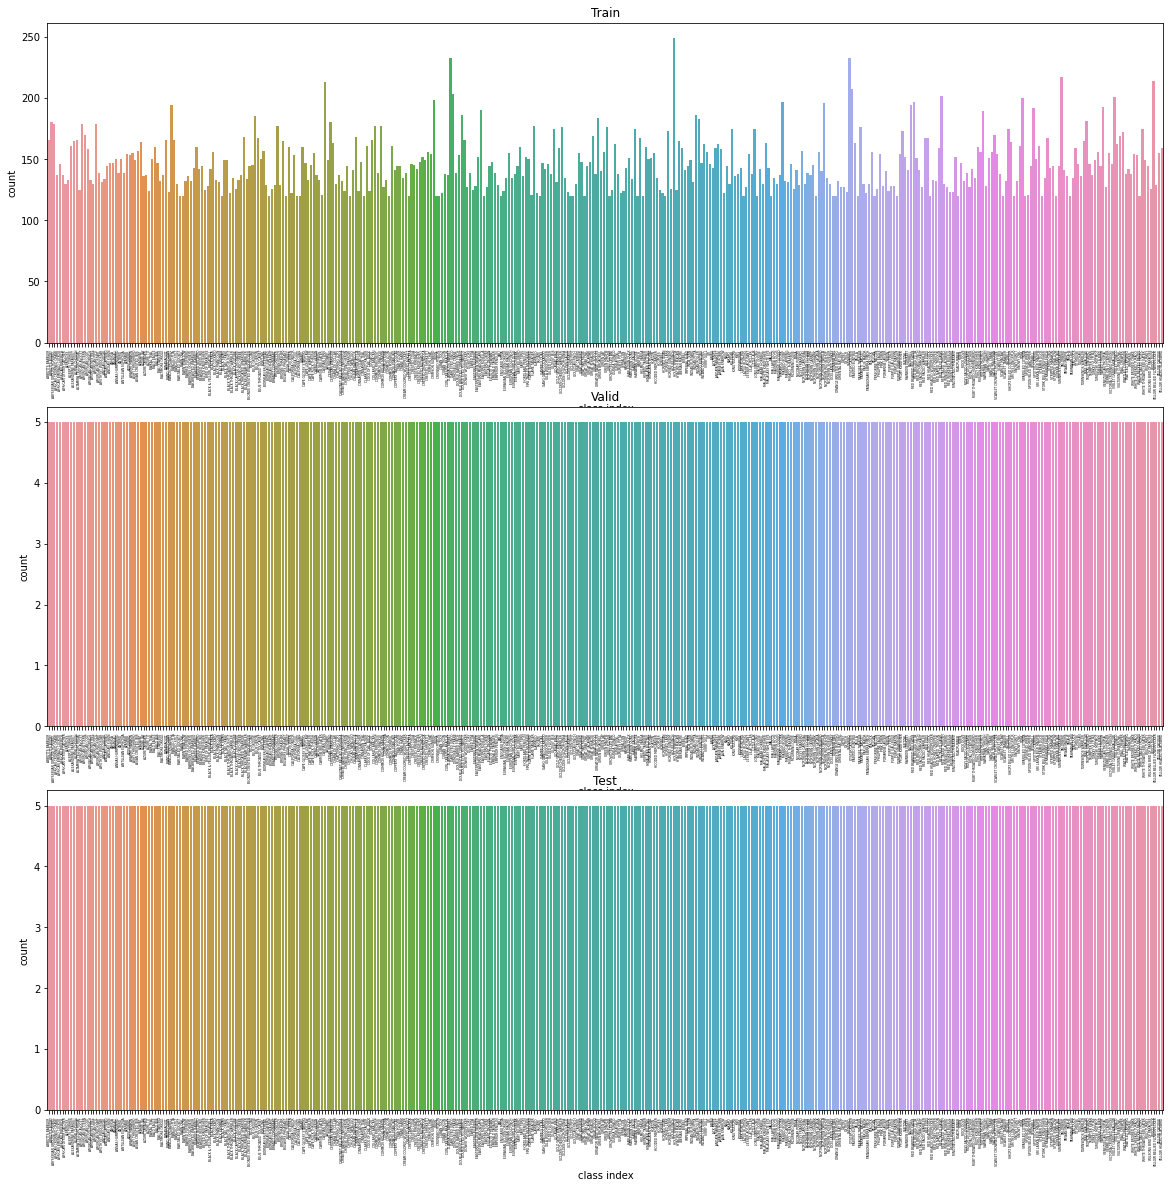

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(20,20))

sns.countplot(x=birds_df_train["class index"], ax=axes[0])
axes[0].set_xticklabels(labels=birds_df_train.labels.unique(), rotation=90, fontsize=3)
axes[0].set_title("Train")

sns.countplot(x=birds_df_valid["class index"], ax=axes[1])
axes[1].set_xticklabels(labels=birds_df_valid.labels.unique(), rotation=90, fontsize=3)
axes[1].set_title("Valid")

sns.countplot(x=birds_df_test["class index"], ax=axes[2])
axes[2].set_xticklabels(labels=birds_df_test.labels.unique(), rotation=90, fontsize=3)
axes[2].set_title("Test");

In [10]:
pd.Series(birds_df_valid["class index"].value_counts())

0      5
263    5
273    5
272    5
271    5
      ..
130    5
129    5
128    5
127    5
399    5
Name: class index, Length: 400, dtype: int64

In [11]:
pd.Series(birds_df_test["class index"].value_counts())

0      5
263    5
273    5
272    5
271    5
      ..
130    5
129    5
128    5
127    5
399    5
Name: class index, Length: 400, dtype: int64

Validation and test set contain 5 images of each specie. The train images are not equally distributed over the classes.

## Plot some example images

In [12]:
def plot_examples(data_path, split='train'):
    # subfolders of species
    subfolders = [x[0] for x in os.walk(os.path.join(data_path, split))][1:]
    folder = []
    for i in range(10):
        folder.append(random.choice(subfolders))
    
    imgs = []
    for f in folder:
        images = glob.glob(f"{f}/*.jpg")
        image = random.choice(images)
        img_path = os.path.join(image)
        imgs.append(mpimg.imread(img_path))
        
    fig, axes = plt.subplots(2, 5, figsize=(20,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        ax.set_title(folder[i].split('/')[-1])
        ax.set_xticks([])
        ax.set_yticks([]);

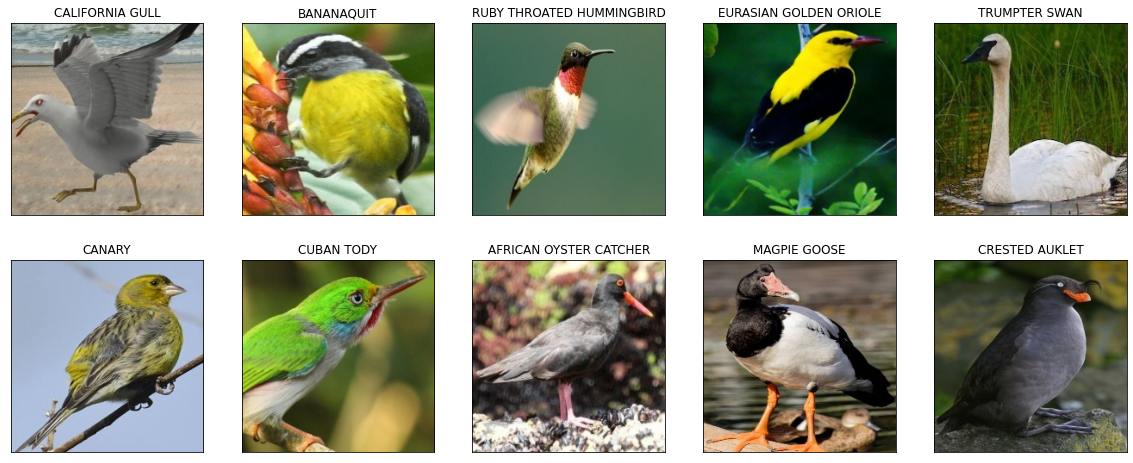

In [13]:
plot_examples(data_path, split='train')

## Data Preparations

* Define transformations and load the data using pytorch ```ImageFolder```

In [14]:
img_size = 64

In [15]:
train_transforms = transforms.Compose([transforms.Resize((img_size, img_size)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                       ])
val_transforms = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
test_transforms = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])

datadir_train = "data/train"
datadir_val = "data/valid"
datadir_test = "data/test"

train_data = datasets.ImageFolder(datadir_train,       
                    transform=train_transforms)
val_data = datasets.ImageFolder(datadir_val,
                    transform=val_transforms)
test_data = datasets.ImageFolder(datadir_test,
                    transform=test_transforms)



# The Model
* Use a pretrained model

In [16]:
BirdsClassifier = models.vgg16(pretrained = True)

In [17]:
# Freeze model weights
for param in BirdsClassifier.parameters():
    param.requires_grad = False

In [18]:
BirdsClassifier

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# change the classifier
# credits: https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification
BirdsClassifier.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 400)
)

In [20]:
BirdsClassifier

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Define the training Loop

In [21]:
def train(model, epoch, device, train_loader, criterion, optimizer):
    
    train_loss = []
    predictions = []
    correct = 0
    
    model.train()
    # loop over batches
    loop = tqdm(enumerate(train_loader), leave=False, total=len(train_loader))
    for idx, (img, label) in loop:
            
        # set to device
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        # forward pass
        y_hat = model(img)
    
        # loss
        loss = criterion(y_hat, label)
        train_loss.append(loss)
        
        # backward
        loss.backward()
        
        # update the weights
        optimizer.step()
    
        y_pred = y_hat.argmax(dim=-1, keepdims=True)
        predictions.append(y_pred)
        correct += y_pred.eq(label.view_as(y_pred)).sum().item()
        accuracy = correct/(idx+1)
        
        # update progess bar
        loop.set_description(f'Train Epoch {epoch}/{epochs}')
        loop.set_postfix(loss=loss.item(), acc=accuracy*100)
    
    # total training loss over all batches
    train_loss = torch.mean(torch.tensor(train_loss))
    epoch_accuracy = correct/len(train_loader.dataset)
    
    loop.set_postfix(train_loss=train_loss.item(), accuracy=100. * epoch_accuracy)
    return train_loss, epoch_accuracy

In [22]:
def validation(model, device, val_loader):
    
    val_loss = []
    predictions = []
    correct = 0
    
    model.eval()
    # loop over batches
    with torch.no_grad():
        loop = tqdm(enumerate(val_loader), leave=False, total=len(val_loader))
        for idx, (img, label) in loop:
            
            # set to device
            img, label = img.to(device), label.to(device)
        
            # forward pass
            y_hat = model(img)
    
            # loss
            loss = criterion(y_hat, label)
            val_loss.append(loss)
    
            y_pred = y_hat.argmax(dim=-1, keepdims=True)
            predictions.append(y_pred)
            correct += y_pred.eq(label.view_as(y_pred)).sum().item()
    
            # update progess bar
            loop.set_description(f'Val Epoch {epoch}/{epochs}')
            accuracy = correct/(idx+1)
            loop.set_postfix(loss=loss.item(), acc=accuracy*100)
    
    # total training loss over all batches
    val_loss = torch.mean(torch.tensor(val_loss))
    epoch_accuracy = correct/len(val_loader.dataset)
    loop.set_postfix(val_loss=val_loss.item(), accuracy=100. * epoch_accuracy)
    
    return val_loss, epoch_accuracy, predictions

# Train the Model

## Set the Hyperparameters

In [32]:
# hyperparameters
batch_size = 64
epochs = 10
learning_rate = 0.001

## Load the Data

In [33]:
train_loader = torch.utils.data.DataLoader(train_data,
                   shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data,
                   shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,
                   shuffle=False, batch_size=batch_size)

In [34]:
print(f'image dataloader item: {next(iter(train_loader))[0].shape}')
print(f'label dataloader length of item: {len(next(iter(train_loader))[1])}')

image dataloader item: torch.Size([64, 3, 64, 64])
label dataloader length of item: 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


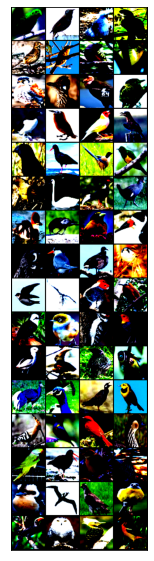

In [35]:
# Visualize one training batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = BirdsClassifier.to(device)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define loss 
criterion = nn.CrossEntropyLoss()

train_losses_epoch = []
val_losses_epoch = []
train_acc_epoch = []
val_acc_epoch = []
preds_epoch = []

for epoch in range(epochs):
    
    train_loss, train_epoch_accuracy = train(model, epoch, device, train_loader, criterion, optimizer)
    train_losses_epoch.append(train_loss)
    train_acc_epoch.append(train_epoch_accuracy)
    
    val_loss, val_epoch_accuracy, predictions = validation(model, device, val_loader)
    val_losses_epoch.append(val_loss)
    val_acc_epoch.append(val_epoch_accuracy)
    preds_epoch.append(predictions)
    
    print(f'epoch {epoch} finished')
    print(f"epoch {epoch}/{epochs}, train loss={train_loss}, val loss={val_loss}")
    print(f"epoch {epoch}/{epochs}, train acc={train_epoch_accuracy}, test acc={val_epoch_accuracy}")


cuda


epoch 0 finished
epoch 0/10, train loss=4.69244909286499, val loss=3.8667590618133545
epoch 0/10, train acc=0.10267520723436323, test acc=0.187


epoch 1 finished
epoch 1/10, train loss=4.574817657470703, val loss=3.710143566131592
epoch 1/10, train acc=0.10553538398301021, test acc=0.205


epoch 2 finished
epoch 2/10, train loss=4.487567901611328, val loss=3.5611519813537598
epoch 2/10, train acc=0.10865246283482907, test acc=0.2145


epoch 3 finished
epoch 3/10, train loss=4.418398857116699, val loss=3.511146068572998
epoch 3/10, train acc=0.11565732684798247, test acc=0.2125


epoch 4 finished
epoch 4/10, train loss=4.392639636993408, val loss=3.4963831901550293
epoch 4/10, train acc=0.11826060149345756, test acc=0.2215


epoch 5 finished
epoch 5/10, train loss=4.377030372619629, val loss=3.506615400314331
epoch 5/10, train acc=0.11952798520243886, test acc=0.227


epoch 6 finished
epoch 6/10, train loss=4.362088680267334, val loss=3.453707695007324
epoch 6/10, train acc=0.1205555936151264, test acc=0.2275


epoch 7 finished
epoch 7/10, train loss=4.317590713500977, val loss=3.342961311340332
epoch 7/10, train acc=0.12668699047749538, test acc=0.2385


epoch 8 finished
epoch 8/10, train loss=4.33034610748291, val loss=3.4668262004852295
epoch 8/10, train acc=0.12925601150921423, test acc=0.226


epoch 9 finished
epoch 9/10, train loss=4.310140609741211, val loss=3.3372397422790527
epoch 9/10, train acc=0.1289134753716517, test acc=0.24


## Plot the Results

In [ ]:
# plot accuracy of training and validation
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_accuracy, label="Validation", color="#9DC209") 
ax.plot(x, train_epoch_accuracy, label="Training", color="#FF7F50")
ax.set_title(f"Accuracy - final value train:{train_epoch_accuracy[-1]:.2} / valid {val_epoch_accuracy[-1]:.2}")
ax.legend()
ax.set_ylim(0,1);

In [ ]:
# plot loss training and validation
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_losses_epoch, label="Validation", color="#9DC209") 
ax.plot(x, train_losses_epoch, label="Training", color="#FF7F50")
ax.set_title(f"Loss - final value train:{train_losses_epoch[-1]:.2} / valid {val_losses_epoch[-1]:.2}")
ax.legend()
ax.set_ylim(0,1);

## Plot Predictions
Visualize the model's results with some example plots from the validation set.

In [ ]:
# first batch of validation data
X_valid = next(iter(val_dataloader))[0]
y_valid = next(iter(val_dataloader))[1]

fig, axes = plt.subplots(4,10, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_valid[i].reshape(28, 28), cmap="gray")
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[0][i].item()} - True: {int(y_valid[i].item())}',
                color=("green" if predictions[0][i]==y_valid[i] else "red"))

## Test the Model

Download some images and run them through the model.

Before making the predictions, they need to be preprocessed as in the training.

In [ ]:
# data path

# load image

# preprocess

# predictions